I dati utilizzati in questo notebook sono stati presi dalla competizione di Kaggle [Twitter Sentiment Analysis](https://www.kaggle.com/c/twitter-sentiment-analysis2).

# Analisi del sentimento

## Indice

1. [Twitter Sentiment Analysis](#twitter)<br>
    1.1 [Descrizione](#descrizione)<br>
2. [Analisi lessicale](#lessicale)<br>
    2.1 [Sostituire pattern specifici](#sostituire)<br>
    2.2 [Ridurre il tweet in *token*](#token)<br>
    2.3 [Rimuovere le *stop word*](#stop_word)<br>
    2.4 [Ridurre i *token* alla radice (*stemming*)](#stemming)<br>
3. [Analisi esplorativa](#esplorativa)<br>
    3.1 [Preparare i dati per l'analisi esplorativa](#preparare)<br>
    3.2 [Visualizzare i *token* e gli *hashtag* più frequenti dividendo tra tweet positivi e negativi](#token_hashtag)<br>
5. [Metriche di classificazione](#metriche)<br>
5. [Classificare i tweet](#classificare)<br>
    5.1 [Creare una baseline](#baseline)<br>
    5.2 [Creare una pipeline di classificazione](#pipeline)<br>  
6. [Analizzare la performance del modello](#performance)<br>
7. [Analizzare il modello stimato](#analizzare_modello)<br>
8. [Analizzare gli errori di previsione](#errori)<br>

In [2]:
import inspect
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from scipy.sparse import lil_matrix
%load_ext autoreload
%autoreload 2

# 1. [Twitter Sentiment Analysis](https://www.kaggle.com/c/twitter-sentiment-analysis2) <a id=twitter> </a>

## 1.1 Descrizione <a id=descrizione> </a>

### Description
This contest is taken from the real task of Text Processing.

The task is to build a model that will determine the tone (neutral, positive, negative) of the text. To do this, you will need to train the model on the existing data (train.csv). The resulting model will have to determine the class (neutral, positive, negative) of new texts (test data that were not used to build the model) with maximum accuracy.

> Nota: la descrizione parla di tre classi ma nel dataset sono presenti solo due classi. La metrica nella descrizione sembra essere l'accuratezza ma in Evaluation sembra invece essere l'F1 score. Noi consideriamo il problema come di classificazione binario e utilizzeremo come metrica principale l'F1 score.

### Evaluation
The evaluation metric for this competition is Mean F1-Score. The F1 score, commonly used in information retrieval, measures accuracy using the statistics precision p and recall r. Precision is the ratio of true positives (tp) to all predicted positives (tp + fp). Recall is the ratio of true positives to all actual positives (tp + fn). The F1 score is given by:
$$
F1 = 2\frac{p \cdot r}{p + r}\, \text{where}\, p = \frac{tp}{tp + fp},\,  r = \frac{tp}{tp + fn}
$$
The F1 metric weights recall and precision equally, and a good retrieval algorithm will maximize both precision and recall simultaneously. Thus, moderately good performance on both will be favored over extremely good performance on one and poor performance on the other.

### Leggere i dati

In [4]:
PATH = 'msbd/datasets/twitter'

dati = pd.read_csv(PATH + "/train.csv", encoding="latin")
print("Dimensione del dataset: {} x {}".format(*dati.shape))
dati.head(10)

Dimensione del dataset: 99989 x 3


,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...
5,6,0,or i just worry too much?
6,7,1,Juuuuuuuuuuuuuuuuussssst Chillin!!
7,8,0,Sunny Again Work Tomorrow :-| ...
8,9,1,handed in my uniform today . i miss you ...
9,10,1,hmmmm.... i wonder how she my number @-)


In [5]:
dati["SentimentText"].values

array(['                     is so sad for my APL friend.............',
       '                   I missed the New Moon trailer...',
       '              omg its already 7:30 :O', ...,
       '@CuPcAkE_2120 ya i thought so ',
       "@Cupcake_Dollie Yes. Yes. I'm glad you had more fun with me. ",
       '@cupcake_kayla haha yes you do '], dtype=object)

### Dividere le variabili esplicative dalla variabile risposta

In [27]:
X = dati["abstract"].tolist()

In [29]:
print("Tipo di X: {}".format(type(X)))

Tipo di X: <class 'list'>


#  2. Analisi lessicale <a id=lessicale> </a>

## 2.1 Sostituire pattern specifici <a id=sostituire> </a>

### Sostituire i tag HTML
Per sostituire i tag HTML useremo la libreria [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/).
> Beautiful Soup is a Python library for pulling data out of HTML and XML files. It works with your favorite parser to provide idiomatic ways of navigating, searching, and modifying the parse tree. It commonly saves programmers hours or days of work.

In [30]:
from bs4 import BeautifulSoup

In [6]:
tweet = X[91]
print("Tweet:\n{}".format(tweet))
print("\nTweet dopo aver sostituito i tag HTML:\n{}".format(BeautifulSoup(tweet, "lxml").get_text()))

Tweet:
  Jus Got Hom Fr. TDa Funeral... I'm So Sad! I Cried So Much Times! Much Love Grandpa!&lt;3 I Never Got To Say My Last &quot;Goodbye&quot; to Him.

Tweet dopo aver sostituito i tag HTML:
Jus Got Hom Fr. TDa Funeral... I'm So Sad! I Cried So Much Times! Much Love Grandpa!<3 I Never Got To Say My Last "Goodbye" to Him.


### Sostituire i collegamenti ipertestuali
La sostituzione dei collegamenti ipertestuali verrà effettuata con la libreria [`re`](https://docs.python.org/3/library/re.html) per l'analisi delle espressioni regolari. In questo caso useremo un'espressione semplificata, che individua qualunque stringa di testo che inizia con "http" fino al primo spazio bianco e la sostituisce con la stringa "link".

[Test di espressioni regolari con la libreria `re` di python](https://pythex.org/).

In [31]:
import re

In [8]:
tweet = X[16]
print("Tweet:\n{}".format(tweet))
print("\nTweet dopo aver sostituito i collegamenti ipertestuali:\n{}".format(re.sub("http\S+", " link ", tweet)))

Tweet:
    awhhe man.... I'm completely useless rt now. Funny, all I can do is twitter. http://myloc.me/27HX

Tweet dopo aver sostituito i collegamenti ipertestuali:
    awhhe man.... I'm completely useless rt now. Funny, all I can do is twitter.  link 


## 2.2 Ridurre il tweet in *token* <a id=token> </a>
La *tokenizzazione* è un processo in base al quale grandi quantità di testo vengono divise in parti più piccole, dette *tokens*.

Applicheremo questa operazione mediante il metodo [`TweetTokenizer`](https://kite.com/python/docs/nltk.TweetTokenizer) del pacchetto [`tokenize`](https://www.nltk.org/api/nltk.tokenize.html), libreria [`nltk`](https://www.nltk.org/).

In [5]:
from nltk.tokenize import TweetTokenizer

In [6]:
tokenizer = TweetTokenizer(
    preserve_case = False, # se False: Questo è un ESEMPIO -> ['questo', 'è', 'un', 'esempio']
    reduce_len = True, # se True: ma daiiiii non ci credooooo -> ['ma', 'daiii', 'non', 'ci', 'credooo']
    strip_handles = True # se True: cosa ne pensi @mario? -> ['cosa', 'ne', 'pensi', '?']
)

tweet = "HMMMMMM @xxxyzz.... i wonder how she has my number :D"

print("Tweet:\n{}".format(tweet))
print("\nTweet dopo la riduzione in token:\n{}".format(tokenizer.tokenize(tweet)))

Tweet:
HMMMMMM @xxxyzz.... i wonder how she has my number :D

Tweet dopo la riduzione in token:
['hmmm', '...', 'i', 'wonder', 'how', 'she', 'has', 'my', 'number', ':D']


## 2.3 Rimuovere le *stop word* <a id=stop_word> </a>
Scarichiamo il package opzionale `stopwords` della libreria [`nltk`](https://www.nltk.org/data.html) e poi lo carichiamo e utilizziamo per rimuovere le *stop word* dal nostro corpus di tweet.

In [34]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lorenzo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from nltk.corpus import stopwords
from string import punctuation

### Rimuovere alcune *stop word* predefinite e la punteggiatura

In [7]:
stop_words = stopwords.words('english') + list(punctuation)


tweet = X[16]
print("Tweet originale:\n{}".format(tweet))

tweet = tokenizer.tokenize(tweet)
print("\nTweet dopo la riduzione in token:\n{}".format(tweet))
print("\nTweet dopo la rimozione delle stop words:\n{}".format([token for token in tweet if token not in stop_words]))

NameError: name 'X' is not defined

### Rimuovere i numeri

In [8]:
tweet = "Ciao, sono lorenzo cifelli vengo da montbelluna! bella!!!!,,;"
tweet = tokenizer.tokenize(tweet)
print(tweet)
print("Tweet dopo la riduzione in token:\n{}".format(tweet))
print("\nTweet dopo la rimozione delle stop words:\n{}".format([token for token in tweet if not token.isdigit()]))

['ciao', ',', 'sono', 'lorenzo', 'cifelli', 'vengo', 'da', 'montbelluna', '!', 'bella', '!', '!', '!', ',', ',', ';']
Tweet dopo la riduzione in token:
['ciao', ',', 'sono', 'lorenzo', 'cifelli', 'vengo', 'da', 'montbelluna', '!', 'bella', '!', '!', '!', ',', ',', ';']

Tweet dopo la rimozione delle stop words:
['ciao', ',', 'sono', 'lorenzo', 'cifelli', 'vengo', 'da', 'montbelluna', '!', 'bella', '!', '!', '!', ',', ',', ';']


## 2.4 Ridurre i *token* alla radice (*stemming*) <a id=stemming> </a>
Il processo di *stemming* è utilizzato nei motori di ricerca per l'espansione di interrogazioni e in altri problemi di elaborazione del linguaggio naturale.

Per lo *stemming* sul nostro corpus useremo l'algoritmo [Snowball Stemmer](https://snowballstem.org/).
E' disponibile anche una versione per la [lingua italiana](https://snowballstem.org/algorithms/italian/stemmer.html).

In [37]:
from nltk.stem.snowball import SnowballStemmer

In [38]:
stemmer = SnowballStemmer("english")

tweet = X[1]
tweet = tokenizer.tokenize(tweet)
print("Tweet dopo la riduzione in token:\n{}".format(tweet))
print("\nTweet dopo la riduzione alla radice dei token:\n{}".format([stemmer.stem(token) for token in tweet]))

Tweet dopo la riduzione in token:
['ceacam', '1', 'is', 'a', 'member', 'of', 'the', 'carcinoembryonic', 'antigen', '(', 'cea', ')', 'family', '.', 'isoforms', 'of', 'murine', 'ceacam', '1', 'serve', 'as', 'receptors', 'for', 'mouse', 'hepatitis', 'virus', '(', 'mhv', ')', ',', 'a', 'murine', 'coronavirus', '.', 'here', 'we', 'report', 'the', 'crystal', 'structure', 'of', 'soluble', 'murine', 'sceacam', '1a', '[', '1,4', ']', ',', 'which', 'is', 'composed', 'of', 'two', 'ig-like', 'domains', 'and', 'has', 'mhv', 'neutralizing', 'activity', '.', 'its', 'n-terminal', 'domain', 'has', 'a', 'uniquely', 'folded', 'ccâ', '\x80', '²', 'loop', 'that', 'encompasses', 'key', 'virus-binding', 'residues', '.', 'this', 'is', 'the', 'first', 'atomic', 'structure', 'of', 'any', 'member', 'of', 'the', 'cea', 'family', ',', 'and', 'provides', 'a', 'prototypic', 'architecture', 'for', 'functional', 'exploration', 'of', 'cea', 'family', 'members', '.', 'we', 'discuss', 'the', 'structural', 'basis', 'of', 

### Esercizio

1. Completare la funzione `tweet_analyzer()` definita in `msbd/preprocessamento/tweet_analyzer.py`. Sulla traccia di quanto visto finora, la funzione dovrà:
   1. Sostituire i tag HTML e i collegamenti ipertestuali;
   2. Trasformare il tweet in una lista di *token*;
   3. Rimuovere le *stop word* (compresi i numeri come visto sopra);
   4. Ridurre i *token* alla radice.
2. Verificare la correttezza della funzione utilizzando pytest.

In [17]:
# per il punto 1C.
# Il valore restituito da `tokenizer.tokenize()` è una lista, che può essere iterata in diversi modi, ad esempio:

lst = ['testo', '1', '2', '3', 'ciao', '!', 'stopword']
print([elem for elem in lst if elem!='stopword' and not elem.isdigit()])

['testo', 'ciao', '!']


In [39]:
from msbd.preprocessamento import tweet_analyzer

print(inspect.getsource(tweet_analyzer))

def tweet_analyzer(tweet, tokenizer, stemmer, stop_words):
    # ============== YOUR CODE HERE ==============
    tweet = BeautifulSoup(tweet, "lxml").get_text()
    tweet = re.sub("http\S+", " link ", tweet)
    tweet = tokenizer.tokenize(tweet)
    tweet = [stemmer.stem(token) for token in tweet if token not in stop_words
        and not token.isdigit()]
    # ============== YOUR CODE HERE ==============

    return tweet



In [19]:
!pytest -p no:warnings -v msbd/tests/test_tweet_analyzer.py 

============================= test session starts =============================
platform win32 -- Python 3.7.6, pytest-5.4.1, py-1.8.1, pluggy-0.13.1 -- C:\Users\Lorenzo\anaconda3\envs\msbd\python.exe
cachedir: .pytest_cache
hypothesis profile 'default' -> database=DirectoryBasedExampleDatabase('C:\\Users\\Lorenzo\\Desktop\\STUDY\\Big Data\\.hypothesis\\examples')
rootdir: C:\Users\Lorenzo\Desktop\STUDY\Big Data
plugins: hypothesis-5.5.4, arraydiff-0.3, astropy-header-0.1.2, doctestplus-0.5.0, openfiles-0.4.0, remotedata-0.3.2
collecting ... collected 7 items

msbd/tests/test_tweet_analyzer.py::test_ridurre_in_token PASSED          [ 14%]
msbd/tests/test_tweet_analyzer.py::test_sostituire_tag_html PASSED       [ 28%]
msbd/tests/test_tweet_analyzer.py::test_sostituire_collegamenti_ipertestuali PASSED [ 42%]
msbd/tests/test_tweet_analyzer.py::test_rimuovere_stop_words PASSED      [ 57%]
msbd/tests/test_tweet_analyzer.py::test_rimuovere_numeri PASSED          [ 71%]
msbd/tests/test_tweet_

### Esempio di tweet dopo il preprocessamento

In [20]:
tweet = "@student! analyze this &lt;3 tweeeet;, solution at http://www.fakelink.com :D 42 #42"
print("Tweet:\n{}".format(tweet))
print("\nTweet dopo la riduzione alla radice dei token:\n{}".format(tweet_analyzer(tweet, tokenizer, stemmer, stop_words)))

Tweet:
@student! analyze this &lt;3 tweeeet;, solution at http://www.fakelink.com :D 42 #42

Tweet dopo la riduzione alla radice dei token:
['analyz', '<3', 'tweeet', 'solut', 'link', ':d', '#42']


# 3. Analisi esplorativa <a id=esplorativa> </a>

### Dividiere i dati in training e test

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print("# tweet in train: {} ({} pos / {} neg)".format(len(X_train), (y_train == 1).sum(), (y_train == 0).sum()))
print("# tweet in test: {}".format(len(X_test)))

# tweet in train: 89990 (50809 pos / 39181 neg)
# tweet in test: 9999


## 3.1 Preparare i dati per l'analisi esplorativa <a id=preparare> </a>

### Preprocessare i tweet

In [40]:
import tqdm

In [41]:
X_preproc = [tweet_analyzer(tweet, tokenizer, stemmer, stop_words) for tweet in tqdm.tqdm(X)]

  0%|                                                                              | 20/59887 [00:00<05:01, 198.56it/s]

TypeError: object of type 'float' has no len()

  0%|                                                                              | 20/59887 [00:19<05:01, 198.56it/s]

In [24]:
print(type(X_preproc))
print(X_preproc[:10])

<class 'list'>
[['ooo', 'think', 'need', 'speak', 'greg', 'fellow', 'want', 'tip', 'look', 'forward', 'releas', 'book'], ['@blonddie38', '@beth_warren', 'belt', 'thing', 'collect', 'realli', 'cool', 'belt', 'buckl', 'seem', 'help'], ['cool', 'man', 'glad', 'enjoy'], ['got', 'stage', 'enough', 'enough'], ["can't", 'wait', 'see', 'kind', 'nois', 'two', 'make', 'next', 'season', '...', 'draft', 'go', 'miss'], ['love', 'get', 'call', 'extend', 'famili', 'year', 'old', 'comput', 'infest', 'malwar', 'expect', 'fix'], ['hit', 'martini', 'ranch', 'lot', 'awesom', 'cheap', 'skank', 'come', 'place', 'tonight'], ['miss', 'summer'], ['studi', 'save', 'muahahahahahahaha', 'caffien', 'trick'], ['know', 'someth', 'similar', 'happen', 'everytim', 'go', 'see', 'like', 'never', 'want', 'leav', 'ya', 'girl']]


### Creare le liste dei *token* appartenenti a tweet con sentimento positivo e negativo

In [25]:
import itertools

Per maggiori informazioni: [Itertools in Python 3, by example](https://realpython.com/python-itertools/), [Python itertools](https://www.novixys.com/blog/python-itertools-compress-dropwhile-takewhile-groupby/#2_What_does_itertoolscompress_do)

In [26]:
# come funziona il metodo itertools.compress() ?

# da https://www.novixys.com/blog/python-itertools-compress-dropwhile-takewhile-groupby/#2_What_does_itertoolscompress_do
# itertools.compress filtra gli elementi di un oggetto 'iterable' in base ai valori di una seconda lista di selettori.

prima_lista = ['TOY', 'HON', 'GM', 'FRD', 'CHRY']
seconda_lista = ['uno', 'due', 'tre', 'quattro', 'cinque']

prima_lista_filtrata = (list(itertools.compress(prima_lista, [0, 0, 1, 1, 0])))
seconda_lista_filtrata = (list(itertools.compress(seconda_lista, [1, 0, 1])))

print("Prima lista: {}; filtrata: {}".format(prima_lista, prima_lista_filtrata))
print("Seconda lista: {}; filtrata: {}".format(seconda_lista, seconda_lista_filtrata))

Prima lista: ['TOY', 'HON', 'GM', 'FRD', 'CHRY']; filtrata: ['GM', 'FRD']
Seconda lista: ['uno', 'due', 'tre', 'quattro', 'cinque']; filtrata: ['uno', 'tre']


In [27]:
# come funziona il metodo chain.from_iterable() ?

# Paragrafo: Intermission: Flattening A List of Lists
# itertools.chain.from_iterable trasforma (concatenandola) una lista di liste in un'unica lista.

list(itertools.chain.from_iterable([[1, 2, 3], [4, 5, 6]]))

[1, 2, 3, 4, 5, 6]

In [28]:
# combiniamo le due ...
lista_originale = [["uno", "due"], ["tre", "quattro"], ["cinque", "sei"]]
lista_filtro = [1, 0, 1]

list(itertools.chain.from_iterable(list(itertools.compress(lista_originale, lista_filtro))))

['uno', 'due', 'cinque', 'sei']

In [29]:
token_pos = list(itertools.chain.from_iterable(list(itertools.compress(X_preproc, y_train == 1))))
token_neg = list(itertools.chain.from_iterable(list(itertools.compress(X_preproc, y_train == 0))))

In [30]:
print("token appartenenti a tweet classificati con sentimento positivo:\n{}".format(token_pos[:10]))

print("\ntoken appartenenti a tweet classificati con sentimento negativo:\n{}".format(token_neg[:10]))

token appartenenti a tweet classificati con sentimento positivo:
['ooo', 'think', 'need', 'speak', 'greg', 'fellow', 'want', 'tip', 'look', 'forward']

token appartenenti a tweet classificati con sentimento negativo:
['@blonddie38', '@beth_warren', 'belt', 'thing', 'collect', 'realli', 'cool', 'belt', 'buckl', 'seem']


### Creare le liste degli *hashtag* appartenenti a tweet con sentimento postivo e negativo

In [31]:
hashtag_pos = [token for token in token_pos if token.startswith("#")]
hashtag_neg = [token for token in token_neg if token.startswith("#")]

print("hashtag appartenenti a tweet classificati con sentimento positivo:\n{}".format(hashtag_pos[:10]))

print("\nhashtag appartenenti a tweet classificati con sentimento negativo:\n{}".format(hashtag_neg[:10]))

hashtag appartenenti a tweet classificati con sentimento positivo:
['#jaljeera', '#timtam', '#30secondstomarsiscom', '#eurovis', '#pen', '#ikea', '#railfan', '#at', '#chesterday', '#phpkonferenca']

hashtag appartenenti a tweet classificati con sentimento negativo:
['#irememb', '#spymast', '#inaperfectworld', '#andnav', '#irememb', '#annalowmanisamassivelos', '#inaperfectworld', '#inaperfectworld', '#inaperfectworld', '#inaperfectworld']


## 3.2 Visualizzare i *token* e gli *hashtag* più frequenti dividendo tra tweet positivi e negativi <a id=token_hashtag> </a>

### Creare un'istanza della classe [`Counter`](https://docs.python.org/3/library/collections.html#collections.Counter) per ogni lista

In [32]:
from collections import Counter

In [33]:
c_token_pos = Counter(token_pos)
c_token_neg = Counter(token_neg)
c_hashtag_pos = Counter(hashtag_pos)
c_hashtag_neg = Counter(hashtag_neg)

### Grafici a barre

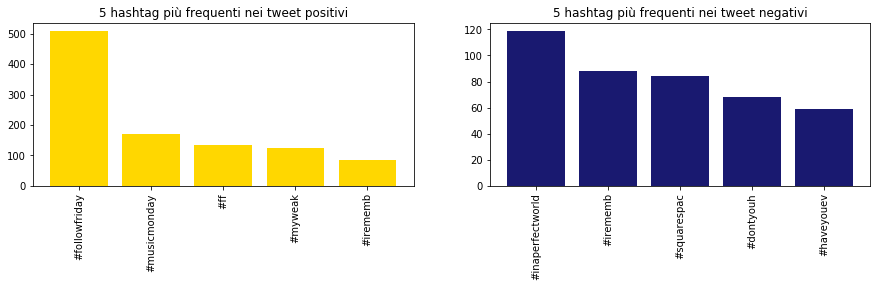

In [34]:
N = 5

plt.figure(figsize=(15, 3))

plt.subplot(121)
plt.title("{} hashtag più frequenti nei tweet positivi".format(N))
plt.bar(*zip(*c_hashtag_pos.most_common(N)), color="gold")
plt.xticks(rotation="vertical")

plt.subplot(122)
plt.title("{} hashtag più frequenti nei tweet negativi".format(N))
plt.bar(*zip(*c_hashtag_neg.most_common(N)), color="midnightblue")
plt.xticks(rotation="vertical")

plt.show()

In [35]:
# Formattazione dei valori per plt.bar:
cc = Counter(["pippo", "pluto", "paperino", "paperino", "paperino", "paperino", "minnie", "pippo"])

print("Oggetto zip:", zip(*cc.most_common(2)))
print("Formato accettato da pyplot.bar: ", *zip(*cc.most_common(2)))

Oggetto zip: <zip object at 0x0000017E1AE4D248>
Formato accettato da pyplot.bar:  ('paperino', 'pippo') (4, 2)


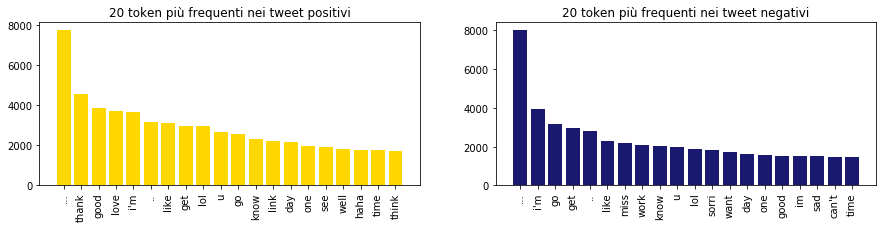

In [36]:
N = 20

plt.figure(figsize=(15, 3))

plt.subplot(121)
plt.title("{} token più frequenti nei tweet positivi".format(N))
plt.bar(*zip(*c_token_pos.most_common(N)), color="gold")
plt.xticks(rotation="vertical")

plt.subplot(122)
plt.title("{} token più frequenti nei tweet negativi".format(N))
plt.bar(*zip(*c_token_neg.most_common(N)), color="midnightblue")
plt.xticks(rotation="vertical")

plt.show()

### Wordcloud

In [37]:
!pip install wordcloud

In [38]:
from wordcloud import WordCloud

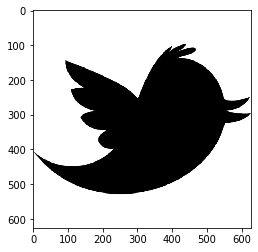

In [39]:
MASK = plt.imread("figures/twitter.jpg")
MAX_WORDS = 200
MAX_FONT_SIZE = 200
RELATIVE_SCALING = 1

plt.show()
plt.imshow(MASK)

wc_pos = WordCloud(
    mask=MASK,
    max_words=MAX_WORDS, 
    background_color="white",
    max_font_size=MAX_FONT_SIZE,
    relative_scaling=RELATIVE_SCALING,
).generate_from_frequencies(c_token_pos)

wc_neg = WordCloud(
    mask=MASK[:, ::-1, :],
    max_words=MAX_WORDS,
    background_color="midnightblue",
    max_font_size=MAX_FONT_SIZE,
    relative_scaling=RELATIVE_SCALING,
    colormap=plt.cm.YlOrRd
).generate_from_frequencies(c_token_neg)

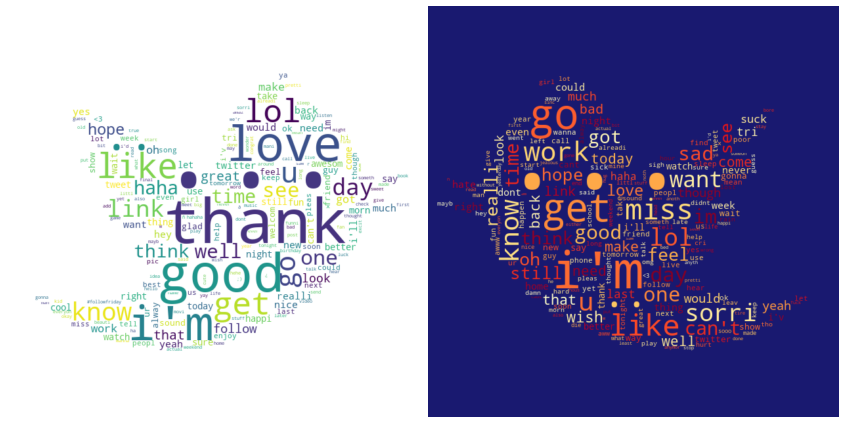

In [40]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis("off")

plt.subplot(122)
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis("off")

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# 4. Metriche di classificazione <a id=metriche> </a>

### Matrice di confusione e metriche derivabili da essa

![confusion_matrix](figures/confusion_matrix.png)

*Immagine presa dalla pagina [Confusion_matrix](https://en.wikipedia.org/wiki/Confusion_matrix) di Wikipedia.*

### Esercizio

1. Completare i metodi della classe `MetricheClassificazione` definita in `msbd/preprocessamento/metriche.py`;
2. Verificare la corettezza dei metodi definiti utilizzando pytest.

> Suggerimenti: 
> 1. Prendere ispirazione dai metodi già definiti;
> 2. Eseguire il controllo con pytest ogni volta che si definisce un nuovo metodo.

La classe `MetricheClassificazione`, rispetto alle altre viste finora, non ha un metodo `__init__()` di inizializzazione ed i suoi metodi non hanno il parametro `self`, ma usano il decoratore `@static`.

Tutti i metodi della classe possono essere invocati su oggetti che non sono istanze della classe, infatti non dichiariamo nessuna nuova istanza di `MetricheClassificazione`. 

In [41]:
from msbd.metriche import MetricheClassificazione

#print(inspect.getsource(MetricheClassificazione))

In [42]:
!pytest -p no:warnings -v msbd/tests/test_metriche_classificazione.py

============================= test session starts =============================
platform win32 -- Python 3.7.6, pytest-5.4.1, py-1.8.1, pluggy-0.13.1 -- C:\Users\Lorenzo\anaconda3\envs\msbd\python.exe
cachedir: .pytest_cache
hypothesis profile 'default' -> database=DirectoryBasedExampleDatabase('C:\\Users\\Lorenzo\\Desktop\\STUDY\\Big Data\\.hypothesis\\examples')
rootdir: C:\Users\Lorenzo\Desktop\STUDY\Big Data
plugins: hypothesis-5.5.4, arraydiff-0.3, astropy-header-0.1.2, doctestplus-0.5.0, openfiles-0.4.0, remotedata-0.3.2
collecting ... collected 13 items

msbd/tests/test_metriche_classificazione.py::test_n_negativi PASSED      [  7%]
msbd/tests/test_metriche_classificazione.py::test_n_positivi PASSED      [ 15%]
msbd/tests/test_metriche_classificazione.py::test_n_previsti_negativi PASSED [ 23%]
msbd/tests/test_metriche_classificazione.py::test_n_previsti_positivi PASSED [ 30%]
msbd/tests/test_metriche_classificazione.py::test_n_veri_negativi PASSED [ 38%]
msbd/tests/test_metriche

### Esempio

In [43]:
y_true = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
y_pred = np.array([0, 0, 0, 1, 0, 0, 1, 1, 1, 1])

print("### Metriche di classificazione (classe MetricheClassificazione):")
print("# negativi: {}".format(MetricheClassificazione.n_negativi(y_true, y_pred)))
print("# positivi: {}".format(MetricheClassificazione.n_positivi(y_true, y_pred)))
print("# previsti negativi: {}".format(MetricheClassificazione.n_previsti_negativi(y_true, y_pred)))
print("# previsti positivi: {}".format(MetricheClassificazione.n_previsti_positivi(y_true, y_pred)))
print()
print("Matrice di confusione:")
print("# veri negativi: {}".format(MetricheClassificazione.n_veri_negativi(y_true, y_pred)))
print("# falsi positivi: {}".format(MetricheClassificazione.n_falsi_positivi(y_true, y_pred)))
print("# falsi negativi: {}".format(MetricheClassificazione.n_falsi_negativi(y_true, y_pred)))
print("# veri positivi: {}".format(MetricheClassificazione.n_veri_positivi(y_true, y_pred)))
print()
print("Tasso falsi positivi: {:.2f}".format(MetricheClassificazione.tasso_falsi_positivi(y_true, y_pred)))
print("Tasso veri positivi: {:.2f}".format(MetricheClassificazione.tasso_veri_positivi(y_true, y_pred)))
print("Precisione: {:.2f}".format(MetricheClassificazione.precisione(y_true, y_pred)))
print("Richiamo: {:.2f}".format(MetricheClassificazione.richiamo(y_true, y_pred)))
print("Punteggio F1: {:.2f}".format(MetricheClassificazione.punteggio_f1(y_true, y_pred)))

from sklearn.metrics import confusion_matrix, classification_report

print("\n\n### Metriche di classificazione (classi di sklearn):")
mc = confusion_matrix(y_true, y_pred, labels=[0, 1])
print("Matrice di confusione DummyClassifier: \n {} \n".format(mc))

cr = classification_report(y_true, y_pred, output_dict=False, target_names=["zero","uno"])
print("\nReport di classificazione DummyClassifier: \n {}".format(cr))


### Metriche di classificazione (classe MetricheClassificazione):
# negativi: 4
# positivi: 6
# previsti negativi: 5
# previsti positivi: 5

Matrice di confusione:
# veri negativi: 3
# falsi positivi: 1
# falsi negativi: 2
# veri positivi: 4

Tasso falsi positivi: 0.25
Tasso veri positivi: 0.67
Precisione: 0.80
Richiamo: 0.67
Punteggio F1: 0.73


### Metriche di classificazione (classi di sklearn):
Matrice di confusione DummyClassifier: 
 [[3 1]
 [2 4]] 


Report di classificazione DummyClassifier: 
               precision    recall  f1-score   support

        zero       0.60      0.75      0.67         4
         uno       0.80      0.67      0.73         6

    accuracy                           0.70        10
   macro avg       0.70      0.71      0.70        10
weighted avg       0.72      0.70      0.70        10



# 5. Classificare i tweet <a id=classificare> </a>

## 5.1 Creare una baseline <a id=baseline> </a>

In [44]:
from msbd.grafici import grafico_matrice_confusione
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

Precisione: 0.56
Richiamo: 1.00
F1 score: 0.72


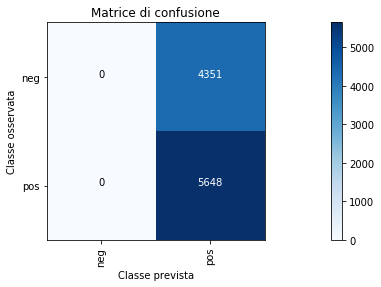

In [45]:
dc = DummyClassifier(strategy="most_frequent")

dc.fit(X_train, y_train)

y_pred = dc.predict(X_test)

precisione_baseline = precision_score(y_test, y_pred)
richiamo_baseline = recall_score(y_test, y_pred)
f1_score_baseline = f1_score(y_test, y_pred)
print("Precisione: {:.2f}".format(precisione_baseline))
print("Richiamo: {:.2f}".format(richiamo_baseline))
print("F1 score: {:.2f}".format(f1_score_baseline))
grafico_matrice_confusione(y_test, y_pred, ["neg", "pos"])

### Esercizio

`DummyClassifier` ha un F1 score del 73% e un richiamo addirittura del 100%! Ѐ utile in un caso reale la previsione fatta da questo modello? Motivare la risposta e riflettere sul risultato.

# 5.2 Creare una pipeline di classificazione <a id=pipeline> </a>

In [77]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

### Definire la pipeline

Istanziamo due oggetti con le seguenti classi e li inseriamo in una pipeline:
* [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) è un metodo che permette di convertire una collezione di documenti in una matrice di contatori di token.
Si tratta di una matrice "sparsa", in grado di ottimizzare notevolmente l'uso della memoria.
E' possibile fornire tramite il parametro `analyzer` una funzione personalizzata di analisi, in questo caso useremo la nostra `tweet_analyzer`, che esclude le *stop word*, fa la tokenizzazione e lo *stemming*.
* [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) è un classificatore ad albero decisionale della libreria `sklearn` che useremo per cercare una soluzione al problema iniziale.

In [87]:
vect = CountVectorizer(
    analyzer = lambda t: tweet_analyzer(t, tokenizer, stemmer, stop_words),
    min_df = 50,
    max_df = 0.7,
)
tree = DecisionTreeClassifier(min_samples_leaf = 25)
lda = LinearDiscriminantAnalysis()
lr = LogisticRegression()

clf = Pipeline([('vect', vect),('lda', lda)])

clf.fit(X_train.toarray(), y_train)

AttributeError: 'list' object has no attribute 'toarray'

In [91]:
clf.fit_tranform(X.train, y.train)

AttributeError: 'Pipeline' object has no attribute 'fit_tranform'

> Nota: tutti gli iperparametri sono stati scelti "a priori" e, soprattutto, senza prendere decisioni basate sull'insieme di *test*. Volendo scegliere la combinazione di iperparametri migliore tra un insieme di candidati (vedi *grid search*, *random search*, ...), avremmo bisogno anche di un terzo insieme di *validation*. Lo stesso vale per la scelta tra algoritmi diversi (es: `DecisionTreeClassifier`vs `LogisticRegression`).

In [73]:
# Esempio di funzionamento della nostra pipeline, scomponendo i due passaggi

# uso i primi 250 tweet
esempio_X = X_train[:250]
esempio_y = y_train[:250]

# definisco un'istanza di CountVectorizer che usa come analyzer la nostra tweet_analyzer
# restituirà una matrice di conteggi sui token ottenuti (colonne) per ogni documento/tweet (righe)
esempio_vect = CountVectorizer(
    analyzer = lambda t: tweet_analyzer(t, tokenizer, stemmer, stop_words)
)

esempio_X_preproc = esempio_vect.fit_transform(esempio_X)

print("Primi 10 tokens: \n", esempio_vect.get_feature_names()[:10])
print("\nShape della matrice di conteggio: ", esempio_X_preproc.shape)
print("\nMatrice di conteggio dei token: \n", esempio_X_preproc.toarray())

# split train/test
# lo faccio dopo la trasformazione perché devo avere le stesse colonne (token) per entrambi i dataset
esempio_X_preproc_train = esempio_X_preproc[:200]
esempio_X_preproc_test = esempio_X_preproc[201:250]

# Definisco il classificatore e lo alleno con il dataset di training ...
esempio_clf = DecisionTreeClassifier(min_samples_leaf = 25)
esempio_clf.fit(esempio_X_preproc_train, esempio_y[:200])

# Ottengo le previsioni sul dataset di test (privi di senso in questo esempio ridotto)
esempio_clf.predict(esempio_X_preproc_test)

Primi 10 tokens: 
 ['#30secondstomarsiscom', '#andnav', '#at', '#chesterday', '#eurovis', '#ikea', '#inaperfectworld', '#irememb', '#jaljeera', '#pen']

Shape della matrice di conteggio:  (250, 934)

Matrice di conteggio dei token: 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1], dtype=int64)

# 6. Analizzare la performance del modello <a id=performance> </a>

### Stimare, per ogni tweet del test set, la probabilità che il suo sentimento sia positivo

In [79]:
SOGLIA_DECISIONALE = 0.5 # default

# la seconda colonna è quella con le probabilità "1"/sentimento positivo
y_score = clf.predict_proba(X_test)[:, 1]
y_pred = (y_score > SOGLIA_DECISIONALE).astype(int) # equivalente a y_pred = clf.predict(X_test)

### Analizzare la performance del modello fissata la soglia decisionale

Precisione: 0.74 (baseline = 0.56)
Richiamo: 0.84 (baseline = 1.00)
F1 score: 0.79 (baseline = 0.72)


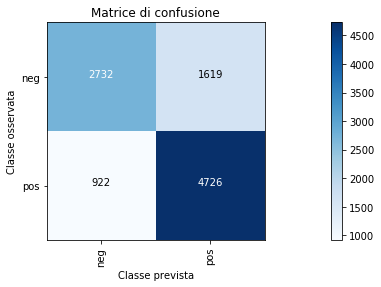

In [80]:
print("Precisione: {:.2f} (baseline = {:.2f})".format(precision_score(y_test, y_pred), precisione_baseline))
print("Richiamo: {:.2f} (baseline = {:.2f})".format(recall_score(y_test, y_pred), richiamo_baseline))
print("F1 score: {:.2f} (baseline = {:.2f})".format(f1_score(y_test, y_pred), f1_score_baseline))
grafico_matrice_confusione(y_test, y_pred, ["neg", "pos"])

### Analizzare le combinazioni di valori ottenibili per le metriche d'interesse al variare della soglia decisionale

In [51]:
y_pred_25 = (y_score > 0.25).astype(int)
y_pred_50 = (y_score > 0.5).astype(int)
y_pred_75 = (y_score > 0.75).astype(int)

In [52]:
from msbd.grafici import grafico_curva_precisione_richiamo
from msbd.grafici import grafico_curva_roc

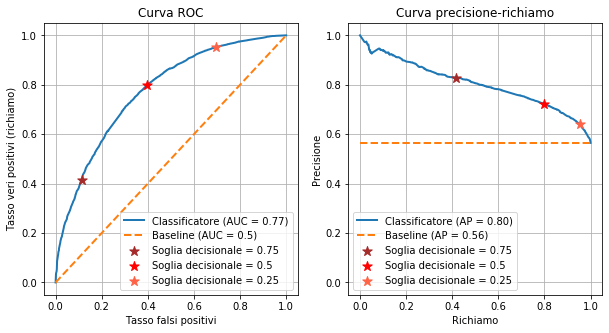

In [53]:
MARKER = "*"
S = 100

plt.figure(figsize=(10, 5))

plt.subplot(121)
grafico_curva_roc(y_test, y_score)
plt.scatter(MetricheClassificazione.tasso_falsi_positivi(y_test, y_pred_75), recall_score(y_test, y_pred_75), 
            marker=MARKER, s=S, c="brown", label="Soglia decisionale = 0.75", zorder=3)
plt.scatter(MetricheClassificazione.tasso_falsi_positivi(y_test, y_pred_50), recall_score(y_test, y_pred_50), 
            marker=MARKER, s=S, c="red", label="Soglia decisionale = 0.5", zorder=3)
plt.scatter(MetricheClassificazione.tasso_falsi_positivi(y_test, y_pred_25), recall_score(y_test, y_pred_25), 
            marker=MARKER, s=S, c="tomato", label="Soglia decisionale = 0.25", zorder=3)
plt.legend()

plt.subplot(122)
grafico_curva_precisione_richiamo(y_test, y_score)
plt.scatter(recall_score(y_test, y_pred_75), precision_score(y_test, y_pred_75), 
            marker=MARKER, s=S, c="brown", label="Soglia decisionale = 0.75", zorder=3)
plt.scatter(recall_score(y_test, y_pred_50), precision_score(y_test, y_pred_50), 
            marker=MARKER, s=S, c="red", label="Soglia decisionale = 0.5", zorder=3)
plt.scatter(recall_score(y_test, y_pred_25), precision_score(y_test, y_pred_25), 
            marker=MARKER, s=S, c="tomato", label="Soglia decisionale = 0.25", zorder=3)
plt.legend()

plt.show()

# 7. Analizzare il modello stimato <a id=analizzare_modello> </a>

### Visualizzare l'albero

In [54]:
from sklearn.tree import export_graphviz
import graphviz

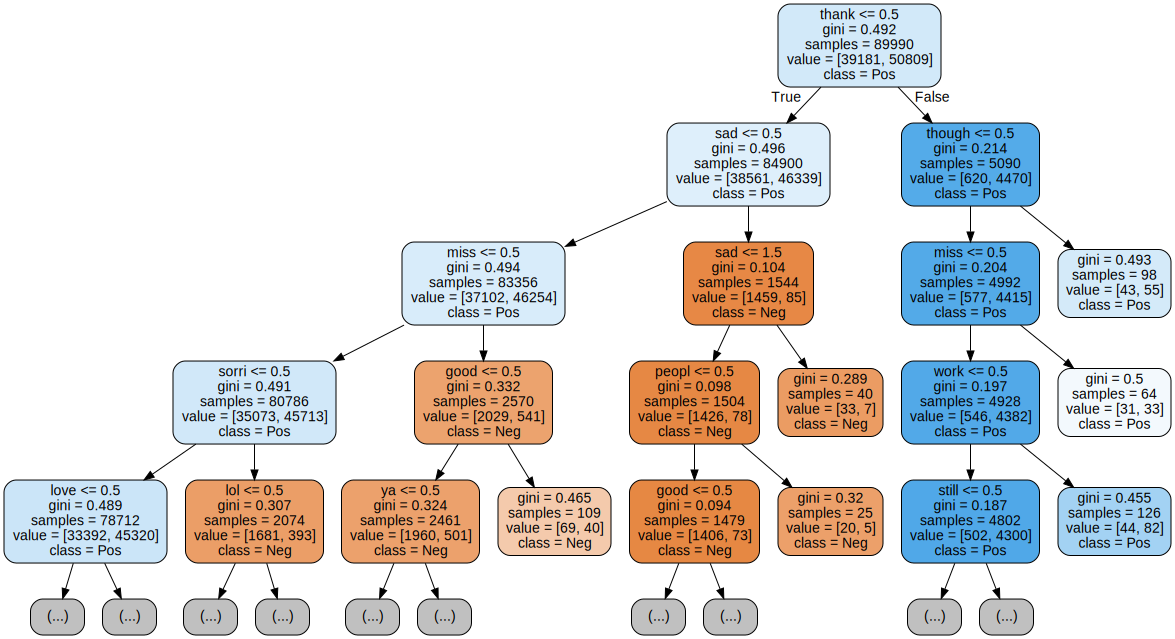

In [55]:
dot_data = export_graphviz(
    decision_tree=clf.named_steps["tree"], 
    max_depth=4,
    feature_names=clf.named_steps["vect"].get_feature_names(),
    class_names=("Neg", "Pos"),
    filled=True,
    rounded=True,
)
display(graphviz.Source(dot_data))

### Visualizzare l'importanza delle variabili

In [56]:
from msbd.grafici import grafico_importanza_variabili

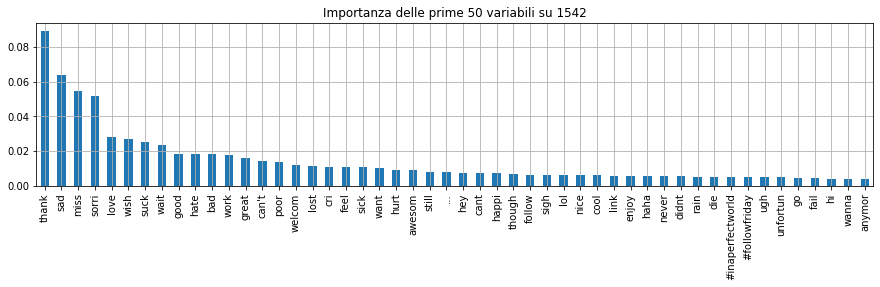

In [57]:
MAX_NUM = 50

plt.figure(figsize=(15, 3))

variabili = clf.named_steps["vect"].get_feature_names()
importanze = clf.named_steps["tree"].feature_importances_

titolo = "Importanza delle prime {} variabili su {}".format(MAX_NUM, len(variabili))

grafico_importanza_variabili(importanze, variabili, max_num=MAX_NUM, titolo=titolo)

plt.show()

# 8. Analizzare gli errori di previsione <a id=errori> </a>

In [58]:
X_test_preproc = [tweet_analyzer(tweet, tokenizer, stemmer, stop_words) for tweet in tqdm.tqdm(X_test)]
tweet_score = pd.DataFrame({"tweet": X_test, "tweet_preproc": X_test_preproc, "score": y_score, 
                            "sentimento": y_test})

100%|████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:05<00:00, 1749.72it/s]


### Vero sentimento negativo, previsto positivo con elevata confidenza

In [59]:
N = 5

print("Primi {} tweet con sentimento negativo previsti con sentimento positivo:".format(N))

for _, riga in tweet_score[tweet_score["sentimento"] == 0].sort_values("score", ascending=False).head(N).iterrows():
    print("\nScore: {:.2f}".format(riga["score"]))
    print("Tweet:\n{}".format(riga["tweet"]))
    print("Tweet dopo il preprocessamento:\n{}".format(riga["tweet_preproc"]))

Primi 5 tweet con sentimento negativo previsti con sentimento positivo:

Score: 1.00
Tweet:
@BornKing15 .. Welcome back KB .. &amp;&amp; I know what you mean I have insomnia as well  ..
Tweet dopo il preprocessamento:
['..', 'welcom', 'back', 'kb', '..', 'know', 'mean', 'insomnia', 'well', '..']

Score: 1.00
Tweet:
@beccatoria BOO.   But welcome back! I just finished watching the deleted scenes. Actually agree with 95% of the cuts this time.
Tweet dopo il preprocessamento:
['boo', 'welcom', 'back', 'finish', 'watch', 'delet', 'scene', 'actual', 'agre', 'cut', 'time']

Score: 1.00
Tweet:
@beeberoni THANKS!  Are you riding the MS150?  If so, please look out for Barb - she's alone 
Tweet dopo il preprocessamento:
['thank', 'ride', 'ms150', 'pleas', 'look', 'barb', 'alon']

Score: 0.98
Tweet:
@bkclubcare Twitterfox hasn't been showing my @ replied for some reason  A belated thank you, Care! I'll definitely be following your tips
Tweet dopo il preprocessamento:
['twitterfox', 'show', 'repli

### Vero sentimento positivo, previsto negativo con elevata confidenza

In [60]:
N = 5

print("Primi {} tweet con sentimento positivo previsti con sentimento negativo:".format(N))

for _, riga in tweet_score[tweet_score["sentimento"] == 1].sort_values("score", ascending=True).head(N).iterrows():
    print("\nScore: {:.2f}".format(riga["score"]))
    print("Tweet:\n{}".format(riga["tweet"]))
    print("Tweet dopo il preprocessamento:\n{}".format(riga["tweet_preproc"]))

Primi 5 tweet con sentimento positivo previsti con sentimento negativo:

Score: 0.00
Tweet:
@Bill_Cecchini hahaha. Sadly I watched that one as well 
Tweet dopo il preprocessamento:
['hahaha', 'sad', 'watch', 'one', 'well']

Score: 0.03
Tweet:
@aravindkumar yeah sadly yes we have power 
Tweet dopo il preprocessamento:
['yeah', 'sad', 'yes', 'power']

Score: 0.03
Tweet:
@ the_bird12 haha its intimidating  and i am sad!
Tweet dopo il preprocessamento:
['the_bird', 'haha', 'intimid', 'sad']

Score: 0.03
Tweet:
@arturs sexual references, sensation soft, sadness - tas tweetpsych ir nelegÄ?ls 
Tweet dopo il preprocessamento:
['sexual', 'refer', 'sensat', 'soft', 'sad', 'tas', 'tweetpsych', 'ir', 'nelegä', 'ls']

Score: 0.03
Tweet:
@androidtomato nuffin much my smuttness. Just home from work. Bit exhausted. Wanna start on my next SPN vclip.  how bout u?
Tweet dopo il preprocessamento:
['nuffin', 'much', 'smutt', 'home', 'work', 'bit', 'exhaust', 'wanna', 'start', 'next', 'spn', 'vclip', 'bout'